In [30]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, low_memory=False)
    df = reduce_mem_usage(df)

    return df

In [4]:
filenames = ["train_all.csv", "data/test_data.csv"]
for filename in filenames:
    print(filename)
    import_data(filename)
    print('---------------------------------------------')

train_all.csv
Memory usage of dataframe is 2459.86 MB
Memory usage after optimization is: 968.11 MB
Decreased by 60.6%
---------------------------------------------
data/test_data.csv
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.38 MB
Decreased by -233.3%
---------------------------------------------


In [5]:
df = import_data("train_all.csv")

Memory usage of dataframe is 2459.86 MB
Memory usage after optimization is: 968.11 MB
Decreased by 60.6%


In [6]:
df_test = import_data("test_all.csv")
df_test.head()

Memory usage of dataframe is 112.10 MB
Memory usage after optimization is: 46.05 MB
Decreased by 58.9%


,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name
0,2021-07-31 00:00:02.035000+00:00,5323264,0,823,1106635517,721367415,55264030,97997774,650.000,260.0000,...,1,0.076904,0.003651,5.000000,5,5,2020,Yargıcı,1182,Elbise
1,2021-07-31 00:00:05.503000+00:00,18238989,1,968,1106636273,721367451,4032918,16332708,105.000,73.5000,...,0,0.000000,0.002827,4.378906,1,5,15508,TRENDYOL MAN,604,T-Shirt
2,2021-07-31 00:00:08.173000+00:00,13354100,1,346,1106635244,721367483,98066435,163202748,79.875,39.9375,...,0,0.000000,0.001260,4.500000,3,5,381,Ltb,581,Deniz Şortu
3,2021-07-31 00:00:10.850000+00:00,49613268,1,335931,1106634651,721367533,87599480,146668239,120.000,65.0000,...,8,0.727051,0.001929,4.070312,1,5,1027526,Meriche,597,Gömlek
4,2021-07-31 00:00:10.989000+00:00,7252871,1,201,1106637202,721367537,96509590,160768055,105.750,59.5000,...,47,0.238525,0.002970,3.941406,1,5,36426,Güneşkızı,604,T-Shirt


In [7]:
sub_data = pd.read_csv("data/test_data.csv")
sub_data
#id: user_id | product_content_id | order_parent_id

,id,expected
0,18115|87073974|726348863,NaN
1,27588|118753298|723169934,NaN
2,29165|35699988|724122443,NaN
3,29969|5893187|722342150,NaN
4,35107|93897418|723421057,NaN
...,...,...
7466,71083899|100019570|728638514,NaN
7467,71106534|35624085|725372928,NaN
7468,71115350|94438742|725291348,NaN
7469,71115350|100017676|725291348,NaN


In [8]:
df_user = pd.read_csv("data/user_demographics.csv")
df_user.head()

,user_id,birth_date,membership_date,gender
0,22013146,NaN,2019-05-09 11:11:17.413000+00:00,Bay
1,49707264,NaN,2020-12-19 18:32:16.240000+00:00,Bay
2,48146878,NaN,2020-11-28 12:26:46.870000+00:00,Bay
3,53528681,NaN,2021-02-01 13:16:24.117000+00:00,Bay
4,17523184,NaN,2018-09-30 22:07:07.623000+00:00,Bay


In [9]:
from datetime import datetime, timezone
now = datetime.now(timezone.utc)

In [10]:
df_user['new_tenure'] = now - pd.to_datetime(df_user['membership_date'], errors='coerce')
df_user['new_tenure'] = df_user['new_tenure'].astype("str")
df_user['tenure'] = df_user['new_tenure'].apply(lambda x: int(x[:x.find("days")]))
df_user.head()

,user_id,birth_date,membership_date,gender,new_tenure,tenure
0,22013146,NaN,2019-05-09 11:11:17.413000+00:00,Bay,1074 days 01:05:52.285831,1074
1,49707264,NaN,2020-12-19 18:32:16.240000+00:00,Bay,483 days 17:44:53.458831,483
2,48146878,NaN,2020-11-28 12:26:46.870000+00:00,Bay,504 days 23:50:22.828831,504
3,53528681,NaN,2021-02-01 13:16:24.117000+00:00,Bay,439 days 23:00:45.581831,439
4,17523184,NaN,2018-09-30 22:07:07.623000+00:00,Bay,1294 days 14:10:02.075831,1294


In [11]:
drop_cols = ["new_tenure", "birth_date", "membership_date"]
df_user.drop(drop_cols, axis=1, inplace=True)

In [12]:
df = df.merge(df_user, on="user_id", how="left")

In [13]:
df.shape

(10702717, 33)

In [14]:
train_0 = df[df.is_returned == 0]
train_1 = df[df.is_returned == 1]

In [15]:
#numeric olan değerleri z_score a veriyorum
z_score = zscore(train_0[['original_price', 'discounted_price', 'coupon_discount', "returnRate",
   "total_claim", "unresolved_claim", "unresolved_accepted_claim", "unresolvedclaim_percentage",
    "defective_returnRate", "review_rates_mean", "review_rates_min", "review_rates_max", "tenure"]])

In [16]:
train_0.shape

(9341481, 33)

In [17]:
abs_zscore = abs(z_score)
train_0 = train_0[(abs_zscore < 3).all(axis=1)]
train_0.shape

(7927629, 33)

In [18]:
df = pd.concat([train_0, train_1])
df.shape

(9288865, 33)

In [19]:
df["discount_ratio"] = df["discounted_price"] / df["original_price"]
df["discount_with_promotion"] = ((df["coupon_discount"] * -1) + (df["promotion_award_value"])).fillna(0) / 100
df["is_saved_card_trx"] = df["is_saved_card_trx"].replace({True: 1, False: 0})
df["has_coupon"] = df["coupon_id"].notna().astype(int)
df["used_promo"] = df["promotion_name"].notna().astype(int)
df["gender"] = df["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": 1, "kvkktalepsilindi": 1})

In [20]:
drop_cols = ["order_date", "coupon_id", "promotion_name", "discounted_price", 
             "promotion_award_value", "coupon_discount", "brand_name", "category_name"]

df.drop(drop_cols, axis=1, inplace=True)
df.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,review_rates_min,review_rates_max,brand_id,category_id,gender,tenure,discount_ratio,discount_with_promotion,has_coupon,used_promo
0,3941815,0,4662,901280147,595758968,95503167,159147197,79.875,8.882812,0,...,1,5,682,604,1,4027,0.650391,0.350098,0,1
3,3941815,0,163,901280149,595758968,36313798,64622938,130.000,9.398438,0,...,1,5,121,604,1,4027,0.461182,0.399902,0,1
4,15996105,1,968,901279297,595758987,96930601,161408176,90.000,9.398438,0,...,2,5,40,1182,1,1458,0.799805,0.199951,0,1
5,11914979,1,968,901280115,595759022,80139132,135798900,57.000,1.342773,0,...,1,5,15508,530,1,2235,0.500000,0.500000,0,1
6,11914979,1,968,901280114,595759022,82581293,139386629,70.000,1.342773,0,...,2,5,15508,601,1,2235,0.399902,0.600098,0,1


In [21]:
df["ship_cost"].fillna(df["ship_cost"].median(), inplace=True)

In [22]:
with open("data/user_return_ratio.txt") as f:
    user_return_ratio = eval(f.read())

In [23]:
df["user_return_ratio"] = df["user_id"].apply(lambda x: user_return_ratio[x])

In [24]:
df.isnull().sum()

user_id                       0
is_elite_user                 0
supplier_id                   0
order_line_item_id            0
order_parent_id               0
product_content_id            0
product_variant_id            0
original_price                0
ship_cost                     0
is_wallet_trx                 0
is_saved_card_trx             0
is_returned                   0
returnRate                    0
total_claim                   0
unresolved_claim              0
unresolved_accepted_claim     0
unresolvedclaim_percentage    0
defective_returnRate          0
review_rates_mean             0
review_rates_min              0
review_rates_max              0
brand_id                      0
category_id                   0
gender                        0
tenure                        0
discount_ratio                2
discount_with_promotion       0
has_coupon                    0
used_promo                    0
user_return_ratio             0
dtype: int64

In [25]:
df[df["discount_ratio"].isna()]["is_returned"]

4143211    0.0
5101449    0.0
Name: is_returned, dtype: float16

In [27]:
df.dropna(subset=['discount_ratio'], inplace=True)

In [29]:
df.shape

(9288863, 30)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(df.drop("is_returned", axis=1),
                                                df["is_returned"], test_size=0.2,
                                                  stratify=df["is_returned"], random_state=0)

### LGBM Model

In [32]:
model = LGBMClassifier(random_state=0)

In [33]:
model.fit(X_train, y_train)

LGBMClassifier(random_state=0)

In [34]:
preds = model.predict(X_val)

print(confusion_matrix(y_val, preds))
print(classification_report(y_val, preds))

[[1554663   30863]
 [  68262  203985]]
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97   1585526
         1.0       0.87      0.75      0.80    272247

    accuracy                           0.95   1857773
   macro avg       0.91      0.86      0.89   1857773
weighted avg       0.94      0.95      0.94   1857773



In [53]:
from sklearn.metrics import f1_score

f1_score(y_val, preds, average='binary')

0.8045238071761702

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

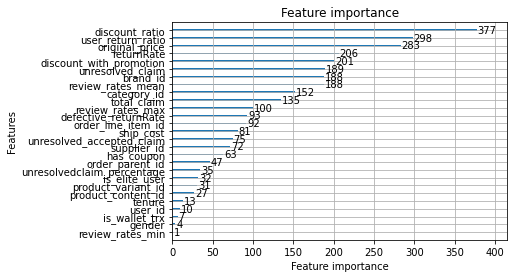

In [50]:
plot_importance(model)

### Preparing Submission File for LGBM Model

In [38]:
df_test = df_test.merge(df_user, on="user_id", how="left")

In [39]:
df_test["discount_ratio"] = df_test["discounted_price"] / df_test["original_price"]
df_test["discount_with_promotion"] = ((df_test["coupon_discount"] * -1) + (df_test["promotion_award_value"])).fillna(0) / 100
df_test["has_coupon"] = df_test["coupon_id"].notna().astype(int)
df_test["used_promo"] = df_test["promotion_name"].notna().astype(int)
df_test["user_return_ratio"] = df_test["user_id"].apply(lambda x: user_return_ratio[x])
df_test["is_saved_card_trx"] = df_test["is_saved_card_trx"].replace({True: 1, False: 0})
df_test["gender"] = df_test["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": 1, "kvkktalepsilindi": 1})

In [40]:
df_test.drop(drop_cols, axis=1, inplace=True)
df_test.shape

(487745, 30)

In [41]:
test_preds = model.predict(df_test[X_train.columns])
df_test["expected"] = test_preds
df_test.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,brand_id,category_id,gender,tenure,discount_ratio,discount_with_promotion,has_coupon,used_promo,user_return_ratio,expected
0,5323264,0,823,1106635517,721367415,55264030,97997774,650.000,8.882812,0,...,2020,1182,1,3850,0.399902,0.000000,0,0,0.842105,1.0
1,18238989,1,968,1106636273,721367451,4032918,16332708,105.000,9.398438,1,...,15508,604,1,1251,0.700195,0.300049,0,1,0.000000,0.0
2,13354100,1,346,1106635244,721367483,98066435,163202748,79.875,10.671875,0,...,381,581,1,1851,0.500000,0.000000,0,0,0.299213,0.0
3,49613268,1,335931,1106634651,721367533,87599480,146668239,120.000,11.328125,0,...,1027526,597,1,484,0.541504,0.399902,0,1,0.000000,0.0
4,7252871,1,201,1106637202,721367537,96509590,160768055,105.750,8.882812,0,...,36426,604,1,3685,0.562500,0.250000,0,1,0.089286,0.0


In [42]:
df_test = df_test.groupby(by=["user_id" , "product_content_id" , "order_parent_id"])["expected"].max().reset_index()

In [43]:
sub_data[["user_id" , "product_content_id" , "order_parent_id"]] = sub_data["id"].str.split("|", expand=True)
sub_data = sub_data[["user_id" , "product_content_id" , "order_parent_id"]].astype(int)
sub_data.head()

,user_id,product_content_id,order_parent_id
0,18115,87073974,726348863
1,27588,118753298,723169934
2,29165,35699988,724122443
3,29969,5893187,722342150
4,35107,93897418,723421057


In [44]:
sub_final = sub_data.merge(df_test, on=["user_id" , "product_content_id" , "order_parent_id"], how="left")
sub_final.expected = sub_final.expected.astype(int)
sub_final.head()

,user_id,product_content_id,order_parent_id,expected
0,18115,87073974,726348863,1
1,27588,118753298,723169934,1
2,29165,35699988,724122443,0
3,29969,5893187,722342150,1
4,35107,93897418,723421057,0


In [45]:
sub_final["id"] = sub_final.apply(lambda x: str(x.user_id) + "|" + 
                                  str(x.product_content_id) + "|" + 
                                  str(x.order_parent_id), axis=1)

sub_final.head()

,user_id,product_content_id,order_parent_id,expected,id
0,18115,87073974,726348863,1,18115|87073974|726348863
1,27588,118753298,723169934,1,27588|118753298|723169934
2,29165,35699988,724122443,0,29165|35699988|724122443
3,29969,5893187,722342150,1,29969|5893187|722342150
4,35107,93897418,723421057,0,35107|93897418|723421057


In [46]:
sub_final.expected.value_counts(normalize=True)

0    0.851559
1    0.148441
Name: expected, dtype: float64

In [47]:
sub_final[["id", "expected"]].to_csv("sub_file_1704.csv", index=False)

In [49]:
sub_final[["id", "expected"]]

,id,expected
0,18115|87073974|726348863,1
1,27588|118753298|723169934,1
2,29165|35699988|724122443,0
3,29969|5893187|722342150,1
4,35107|93897418|723421057,0
...,...,...
7466,71083899|100019570|728638514,1
7467,71106534|35624085|725372928,0
7468,71115350|94438742|725291348,0
7469,71115350|100017676|725291348,0


### XGBoost Model

In [35]:
from xgboost import XGBClassifier

In [36]:
# fit xgboost model
model_xgb = XGBClassifier(random_state=0)
model_xgb.fit(X_train, y_train)

[15:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [37]:
preds_xgb = model_xgb.predict(X_val)

print(confusion_matrix(y_val, preds_xgb))
print(classification_report(y_val, preds_xgb))

[[1555948   29578]
 [  67137  205110]]
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97   1585526
         1.0       0.87      0.75      0.81    272247

    accuracy                           0.95   1857773
   macro avg       0.92      0.87      0.89   1857773
weighted avg       0.95      0.95      0.95   1857773



In [54]:
f1_score(y_val, preds_xgb, average='binary')

0.8092161716985413

### Preparing Submission File for XGBoost Model

In [62]:
df_test_xgb = import_data("test_all.csv")

Memory usage of dataframe is 112.10 MB
Memory usage after optimization is: 46.05 MB
Decreased by 58.9%


In [63]:
df_test_xgb = df_test_xgb.merge(df_user, on="user_id", how="left")
df_test_xgb["discount_ratio"] = df_test_xgb["discounted_price"] / df_test_xgb["original_price"]
df_test_xgb["discount_with_promotion"] = ((df_test_xgb["coupon_discount"] * -1) + (df_test_xgb["promotion_award_value"])).fillna(0) / 100
df_test_xgb["has_coupon"] = df_test_xgb["coupon_id"].notna().astype(int)
df_test_xgb["used_promo"] = df_test_xgb["promotion_name"].notna().astype(int)
df_test_xgb["user_return_ratio"] = df_test_xgb["user_id"].apply(lambda x: user_return_ratio[x])
df_test_xgb["is_saved_card_trx"] = df_test_xgb["is_saved_card_trx"].replace({True: 1, False: 0})
df_test_xgb["gender"] = df_test_xgb["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": 1, "kvkktalepsilindi": 1})

In [64]:
df_test_xgb.drop(drop_cols, axis=1, inplace=True)
df_test_xgb.shape

(487745, 30)

In [65]:
test_preds_xgb = model_xgb.predict(df_test_xgb[X_train.columns])
df_test_xgb["expected"] = test_preds_xgb
df_test_xgb.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,brand_id,category_id,gender,tenure,discount_ratio,discount_with_promotion,has_coupon,used_promo,user_return_ratio,expected
0,5323264,0,823,1106635517,721367415,55264030,97997774,650.000,8.882812,0,...,2020,1182,1,3850,0.399902,0.000000,0,0,0.842105,1.0
1,18238989,1,968,1106636273,721367451,4032918,16332708,105.000,9.398438,1,...,15508,604,1,1251,0.700195,0.300049,0,1,0.000000,0.0
2,13354100,1,346,1106635244,721367483,98066435,163202748,79.875,10.671875,0,...,381,581,1,1851,0.500000,0.000000,0,0,0.299213,0.0
3,49613268,1,335931,1106634651,721367533,87599480,146668239,120.000,11.328125,0,...,1027526,597,1,484,0.541504,0.399902,0,1,0.000000,0.0
4,7252871,1,201,1106637202,721367537,96509590,160768055,105.750,8.882812,0,...,36426,604,1,3685,0.562500,0.250000,0,1,0.089286,0.0


In [66]:
df_test_xgb = df_test_xgb.groupby(by=["user_id" , "product_content_id" , "order_parent_id"])["expected"].max().reset_index()

In [69]:
sub_data_xgb = pd.read_csv("data/test_data.csv")

In [70]:
sub_data_xgb[["user_id" , "product_content_id" , "order_parent_id"]] = sub_data_xgb["id"].str.split("|", expand=True)
sub_data_xgb = sub_data_xgb[["user_id" , "product_content_id" , "order_parent_id"]].astype(int)
sub_data_xgb.head()

,user_id,product_content_id,order_parent_id
0,18115,87073974,726348863
1,27588,118753298,723169934
2,29165,35699988,724122443
3,29969,5893187,722342150
4,35107,93897418,723421057


In [71]:
sub_final_xgb = sub_data_xgb.merge(df_test_xgb, on=["user_id" , "product_content_id" , "order_parent_id"], how="left")
sub_final_xgb.expected = sub_final_xgb.expected.astype(int)
sub_final_xgb.head()

,user_id,product_content_id,order_parent_id,expected
0,18115,87073974,726348863,1
1,27588,118753298,723169934,1
2,29165,35699988,724122443,0
3,29969,5893187,722342150,1
4,35107,93897418,723421057,0


In [72]:
sub_final_xgb["id"] = sub_final_xgb.apply(lambda x: str(x.user_id) + "|" + 
                                  str(x.product_content_id) + "|" + 
                                  str(x.order_parent_id), axis=1)

sub_final_xgb.head()

,user_id,product_content_id,order_parent_id,expected,id
0,18115,87073974,726348863,1,18115|87073974|726348863
1,27588,118753298,723169934,1,27588|118753298|723169934
2,29165,35699988,724122443,0,29165|35699988|724122443
3,29969,5893187,722342150,1,29969|5893187|722342150
4,35107,93897418,723421057,0,35107|93897418|723421057


In [73]:
sub_final_xgb.expected.value_counts(normalize=True)

0    0.837639
1    0.162361
Name: expected, dtype: float64

In [74]:
sub_final_xgb[["id", "expected"]].to_csv("sub_file_1704_xgboost.csv", index=False)